# Customer Segmentation using K-Means Algorithm for Seasonal Profiles

The individual files should contain 3 months data of energy consumption in 15 minute interval

In [1]:
import polars as pl
import glob
from pathlib import Path
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import logging
import re

from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True

from validation import validation

## Select the season for clustering

In [2]:
season = 'winter'  # 'summer' or 'winter'

result_df=pl.read_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/hourly_avg_clustering_{season}.csv')

In [3]:
# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "avg_daily_spring",
        "avg_daily_summer",
        "avg_daily_autumn",
        "avg_daily_winter"
    ]),
    on="ch_id_clean",
    how="left"
)
# Now select in the desired order
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "avg_daily_spring",
    "avg_daily_summer",
    "avg_daily_autumn",
    "avg_daily_winter"
])

#print(result_df.head())

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_yearly_consumption [kWh]"),
    pl.mean("avg_daily_spring").alias("Spring [kWh]").round(1),
    pl.mean("avg_daily_summer").alias("Summer [kWh]").round(1),
    pl.mean("avg_daily_autumn").alias("Autumn [kWh]").round(1),
    pl.mean("avg_daily_winter").alias("Winter [kWh]").round(1),
]).sort("cluster")

# Compute overall averages
overall_yearly_avg = result_df["bruttolastgang_kwh_sum"].mean()
overall_day_avg_spring = result_df['avg_daily_spring'].mean()
overall_day_avg_summer = result_df['avg_daily_summer'].mean()
overall_day_avg_autumn = result_df['avg_daily_autumn'].mean()
overall_day_avg_winter = result_df['avg_daily_winter'].mean()

cluster_summary = cluster_summary.with_columns([
    pl.col("cluster").cast(pl.Utf8)
])
summary_row = pl.DataFrame({
    "cluster": ["Average"],  # Use 0 or a valid UInt32 value for summary row
    "num_households": [result_df["house_id"].n_unique()],
    "avg_yearly_consumption [kWh]": [overall_yearly_avg],
    "Spring [kWh]": [overall_day_avg_spring],
    "Summer [kWh]": [overall_day_avg_summer],
    "Autumn [kWh]": [overall_day_avg_autumn],
    "Winter [kWh]": [overall_day_avg_winter]
})

# Cast to match schema, e.g. cluster and num_households to UInt32
summary_row = summary_row.with_columns([
    pl.col("cluster").cast(cluster_summary["cluster"].dtype),
    pl.col("num_households").cast(cluster_summary["num_households"].dtype)
])

# Concatenate now that dtypes match
final_summary = pl.concat([cluster_summary, summary_row])

print(final_summary)



shape: (6, 7)
┌─────────┬───────────────┬───────────────┬──────────┬───────────────┬──────────────┬──────────────┐
│ cluster ┆ num_household ┆ avg_yearly_co ┆ Spring   ┆ Summer [kWh]  ┆ Autumn [kWh] ┆ Winter [kWh] │
│ ---     ┆ s             ┆ nsumption     ┆ [kWh]    ┆ ---           ┆ ---          ┆ ---          │
│ str     ┆ ---           ┆ [kWh]         ┆ ---      ┆ f64           ┆ f64          ┆ f64          │
│         ┆ u32           ┆ ---           ┆ f64      ┆               ┆              ┆              │
│         ┆               ┆ f64           ┆          ┆               ┆              ┆              │
╞═════════╪═══════════════╪═══════════════╪══════════╪═══════════════╪══════════════╪══════════════╡
│ 1       ┆ 142           ┆ 5974.186908   ┆ 10.3     ┆ 7.8           ┆ 10.6         ┆ 13.6         │
│ 2       ┆ 208           ┆ 7806.525457   ┆ 12.0     ┆ 7.7           ┆ 13.9         ┆ 21.3         │
│ 3       ┆ 412           ┆ 3714.247917   ┆ 6.3      ┆ 5.6           ┆ 6.6   

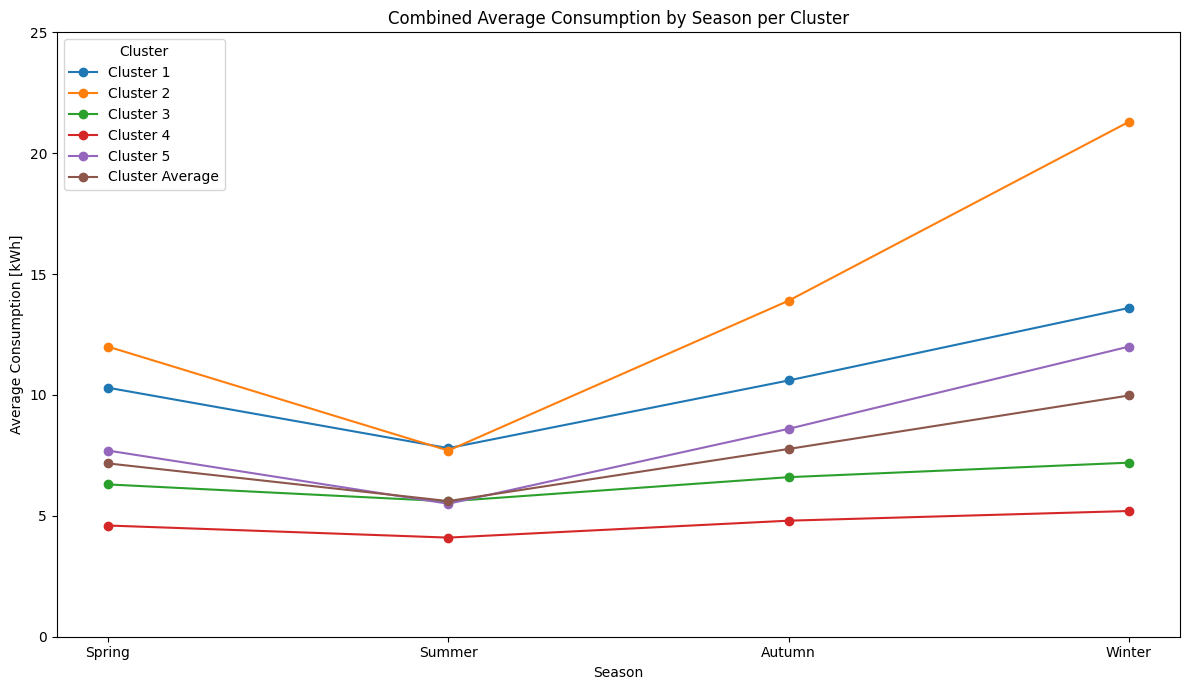

In [4]:
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
clusters = final_summary["cluster"].to_list()

plt.figure(figsize=(12, 7))

for cluster in clusters:
    # Filter the cluster row
    row = final_summary.filter(pl.col("cluster") == cluster).select([
        "Spring [kWh]", "Summer [kWh]", "Autumn [kWh]", "Winter [kWh]"
    ])
    consumption = row[0, :].to_numpy().flatten().tolist()
    plt.plot(seasons, consumption, marker='o', label=f"Cluster {cluster}")

plt.xlabel('Season')
plt.ylabel('Average Consumption [kWh]')
plt.title('Combined Average Consumption by Season per Cluster')
plt.legend(title='Cluster')
plt.ylim(0,25)
plt.grid(False)
plt.tight_layout()
plt.show()